Let's dig in! Give a thumbs up if you liked it! 

Let me know if you have some suggestions and other kind of analysis along similar lines. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

%matplotlib inline 

Netflix Shows.csv



In [2]:
data = pd.read_csv("../input/Netflix Shows.csv", encoding='cp437')
data.head(10)

,title,rating,ratingLevel,ratingDescription,release year,user rating score,user rating size
0,White Chicks,PG-13,"crude and sexual humor, language and some drug...",80,2004,82.0,80
1,Lucky Number Slevin,R,"strong violence, sexual content and adult lang...",100,2006,NaN,82
2,Grey's Anatomy,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,98.0,80
3,Prison Break,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2008,98.0,80
4,How I Met Your Mother,TV-PG,Parental guidance suggested. May not be suitab...,70,2014,94.0,80
5,Supernatural,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,95.0,80
6,Breaking Bad,TV-MA,For mature audiences. May not be suitable for...,110,2013,97.0,80
7,The Vampire Diaries,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2017,91.0,80
8,The Walking Dead,TV-MA,For mature audiences. May not be suitable for...,110,2015,98.0,80
9,Pretty Little Liars,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,96.0,80


## NaN Check. 

Lets check some data sanity. Number of NaN in the data and the columns contributing.

In [3]:
data.isnull().sum()

title                  0
rating                 0
ratingLevel           59
ratingDescription      0
release year           0
user rating score    395
user rating size       0
dtype: int64

## NaN Handling.

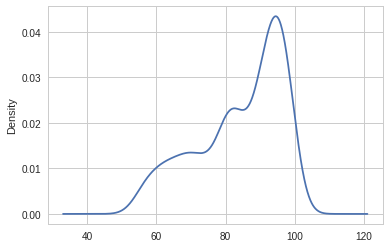

In [4]:
data['user rating score'].dropna().plot(kind = "density")

The data is not in normal distribution. Hence using mean if we were to replace NaN is not a good strategy. We need to replace by
median! Let's check the difference. 

In [5]:
print("The median: {}".format(np.median(data['user rating score'].dropna())))
print("The mean : {}".format(np.mean(data['user rating score'].dropna())))

The median: 88.0
The mean : 84.09421487603306


For simplicity lets fill in the Nan of ratingLevel and user rating score with their respective median scores. 
For ratingLevel since it is a categorical variable, we will take the sum of values and replace NaN with highest occurring value of those counts. 



In [6]:
user_rating_median = np.median(data['user rating score'].dropna())
data['user rating score'] = data['user rating score'].fillna(user_rating_median)



In [7]:
data['ratingLevel'].value_counts().head()

Parents strongly cautioned. May be unsuitable for children ages 14 and under.    224
General Audiences. Suitable for all ages.                                        134
Suitable for all ages.                                                           120
For mature audiences.  May not be suitable for children 17 and under.            110
Parental guidance suggested. May not be suitable for all children.                54
Name: ratingLevel, dtype: int64

In [8]:
fillna_ratingLevel = "Parents strongly cautioned. May be unsuitable for children ages 14 and under."
data['ratingLevel'] = data['ratingLevel'].fillna(fillna_ratingLevel)

In [9]:
#Now after substituing lets check if everything has been done well. 
data.isnull().sum()

title                0
rating               0
ratingLevel          0
ratingDescription    0
release year         0
user rating score    0
user rating size     0
dtype: int64

### Is user rating size necessary?

Let's first see if the last column : user rating size has any variation. With a naked eye it doesn't seem like it!


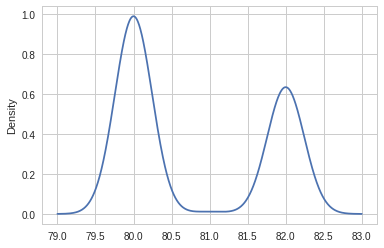

In [10]:
data['user rating size'].plot(kind = "density")

Just a bi-modal data. If we were doing some prediction then this information could have been useful but in EDA,
I dont think we can get any cool patterns from this. 

Let me know if you found any cool patterns. 
I'm removing this feature for now. 


In [11]:
data = data.drop('user rating size', axis=1)

## Year to no of movies released. 

Let's first check for correlation between the two.

In [12]:
movies_in_year = data["release year"].value_counts().to_frame().reset_index()
movies_in_year.columns = ['release year', 'release number']

movies_in_year = movies_in_year.sort_values('release year', ascending = False)

#### Correlation. 

In [13]:
movies_in_year.corr()

,release year,release number
release year,1.000000,0.459705
release number,0.459705,1.000000


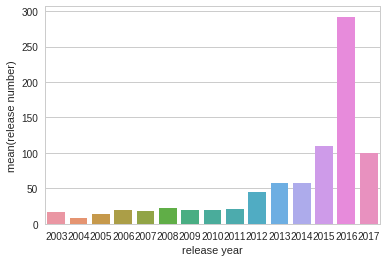

In [14]:
sns.barplot(x = "release year", y = 'release number', data = movies_in_year.head(15))

Looks like there is a clear trend in the year and no of movies released in that year. Infact in the last two years, there seems to be an exponential increase!

We yet do not know upto which month this dataset is valid for in 2017. Hence considering 2017 for this wouldn't be fair. But, even then, it is almost close to number of movies released in 2015!

## Custom Scores!

With an assumption that the ratings present were rating by adults (Obviously.... DUH!)
Lets create a scoring system as below and see if people really like adult content.




In [15]:
data['ratingLevel'].unique()


array(['crude and sexual humor, language and some drug content',
       'strong violence, sexual content and adult language',
       'Parents strongly cautioned. May be unsuitable for children ages 14 and under.',
       'Parental guidance suggested. May not be suitable for all children.',
       'For mature audiences.  May not be suitable for children 17 and under.',
       'language and brief violence', 'Suitable for all ages.',
       'This movie has not been rated.',
       'Suitable for children ages 7 and older.  Content contains fantasy violence.',
       'bloody war violence, language throughout and some sexual material',
       'This movie has not been rated. Intended for adults only and may contain sex, violence, drugs, language or other adult themes.',
       'some thematic elements, rude humor and action',
       'pervasive language, some sexual material, violence and drug use',
       'mild thematic elements',
       'strong crude sexual content, pervasive language, and dr

### Let's create a "adult-ness" score of a film!

lets create a scoring system where we increment score if a word if in the list of following words. 
Lets consider the following as words. 


In [16]:

words = ['rude', 'sex', 'scary', 'violence', 'sex_related', 'adult', 'drug', 'sexual', 'nudity', 'parents', 'children']
#adding parents, children since it is indicative that this isn't for children.

def compute_score(data):
    score = 0
    for i in words:
        if(i in data):
            score = score + data.count(i)
    return(score)

data['adult_score'] = [compute_score(datum) for datum in data['ratingLevel']]

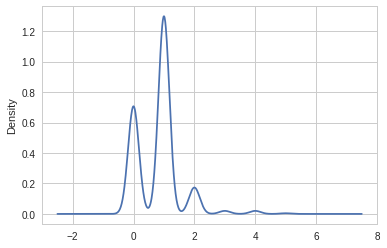

In [17]:
data['adult_score'].plot(kind = "density")

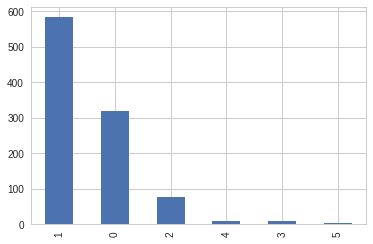

In [18]:
data['adult_score'].value_counts().plot(kind = "bar")

Looks like people make sure there is some amount of adultness in films! 

And next obviously you need films for children and hence >300 instances where we see no adult-ness score!

### What kind of films are there?

In [19]:
data[data['adult_score'] > 3]


,title,rating,ratingLevel,ratingDescription,release year,user rating score,adult_score
0,White Chicks,PG-13,"crude and sexual humor, language and some drug...",80,2004,82.0,4
1,Lucky Number Slevin,R,"strong violence, sexual content and adult lang...",100,2006,88.0,4
38,White Girl,UR,This movie has not been rated. Intended for ad...,124,2016,88.0,5
50,Lucky Number Slevin,R,"strong violence, sexual content and adult lang...",100,2006,88.0,4
87,Meet the Blacks,R,"pervasive language, some sexual material, viol...",100,2016,79.0,4
90,Sausage Party,R,"strong crude sexual content, pervasive languag...",100,2016,91.0,4
101,Lucky Number Slevin,R,"strong violence, sexual content and adult lang...",100,2006,88.0,4
170,Dope,R,"language, drug content, sexuality/nudity, and ...",100,2015,79.0,5
303,Blow,R,"pervasive drug content and language, some viol...",100,2001,78.0,4
334,Magic Mike,R,"pervasive sexual content, brief graphic nudity...",100,2012,77.0,4


I have seen that for score=0 there are many movies which were not rated. Hence lets filter those first and see which ones have 0.


In [20]:

data_adultscore = data.copy()
data_adultscore = data_adultscore[data_adultscore['ratingLevel'] != "This movie has not been rated."]
data_adultscore[data_adultscore['adult_score'] ==0].head(10)

,title,rating,ratingLevel,ratingDescription,release year,user rating score,adult_score
15,Lottie Dottie Chicken,TV-Y,Suitable for all ages.,10,2009,88.0,0
20,Masha and the Bear,TV-Y,Suitable for all ages.,10,2013,81.0,0
88,Finding Dory,PG,mild thematic elements,60,2016,98.0,0
91,Pete's Dragon,PG,"for action, peril and brief language",60,2016,93.0,0
184,Queen of Katwe,PG,"thematic elements, an accident scene and some ...",60,2016,88.0,0
236,The Great Gilly Hopkins,PG,for thematic material and language,60,2016,69.0,0
256,High School Musical 2,TV-G,Suitable for all ages.,35,2007,58.0,0
259,Hannah Montana: The Movie,G,General Audiences. Suitable for all ages.,35,2009,56.0,0
262,StarStruck,TV-G,Suitable for all ages.,35,2010,88.0,0
292,Fuller House,TV-G,Suitable for all ages.,35,2016,90.0,0


In [21]:
del(data_adultscore)

## And.... ofcourse the word cloud! 

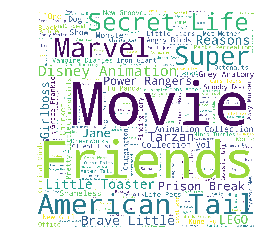

In [22]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=1500,
                          height=1500
                         ).generate(" ".join(data['title']))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()